## Método de colocación con PyTorch


A continuación se implementará el método de colocación utilizando un optimizador y la función de autodiferenciación de PyTorch. 

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore")

## Función de aproximación propuesta

Utilizando una aproximación a la solución de la siguiente forma

$$u_N(x) = \sum_{i=0}^N c_i \phi_i(x) = x (1-x) \sum_{i=0}^N c_i x^i\, ,$$

en donde vemos que esta función satisface las condiciones de frontera.

In [2]:
def funcion_aprox(x, c):
    """Función de aproximación con coeficientes c y variable x"""
    terms = [coef * x**(i + 1) * (1 - x) for i, coef in enumerate(c)]
    return torch.sum(torch.stack(terms), dim=0)


Y el residual estaría dado por

$$R = \frac{d^2 u_N}{dx^2} + u_N + x\, .$$

Considerando el caso de N=3, tenemos que:

$$
-c_0 x^2 + c_0 x - 2c_0 - c_1 x^3 + c_1 x^2 - 6c_1 x + 2c_1 - c_2 x^4 + c_2 x^3 - 12c_2 x^2 + 6c_2 x - c_3 x^5 + c_3 x^4 - 20c_3 x^3 + 12c_3 x^2 + x
$$

In [3]:
def residuo(x, c):
    terms = [
        -c[0]*x**2 + c[0]*x - 2*c[0],
        -c[1]*x**3 + c[1]*x**2 - 6*c[1]*x + 2*c[1],
        -c[2]*x**4 + c[2]*x**3 - 12*c[2]*x**2 + 6*c[2]*x,
        -c[3]*x**5 + c[3]*x**4 - 20*c[3]*x**3 + 12*c[3]*x**2
    ]
    return sum(terms) + x

### Optimización de coeficientes

Optimización de cuatro coeficientes para cuatro valores de $x$.

In [4]:
x = torch.tensor([1/5, 2/5, 3/5, 4/5], requires_grad=True) 

def initialize_coefficients(n):
    std_dev = 1.0 / torch.sqrt(torch.tensor(n, dtype=torch.float32))
    return torch.randn(n) * std_dev

c = initialize_coefficients(4).requires_grad_(True)

# Función de pérdida
def loss_fn(x, c):
    y = residuo(x, c)
    loss = torch.mean(y ** 2)  # Mean squared error
    return loss

optimizer = torch.optim.Adam([c], lr=0.1)

for epoch in range(1_000):  # Number of iterations
    optimizer.zero_grad()  # Clear previous gradients
    loss = loss_fn(x, c)  # Compute loss
    loss.backward()  # Compute gradients
    optimizer.step()  # Update parameters
    
    if epoch % 100 == 0:  # Print progress every 1000 epochs
        print(f'Epoch {epoch}, Loss: {loss.item()}, c: {c.data}')

print(f'Optimized c: {c.data}')

Epoch 0, Loss: 2.5597307682037354, c: tensor([0.1320, 0.1995, 0.2001, 0.6391])
Epoch 100, Loss: 5.1667328079929575e-05, c: tensor([ 0.1834,  0.2291, -0.0967,  0.0470])
Epoch 200, Loss: 2.8991238650633022e-05, c: tensor([ 0.1823,  0.2268, -0.0872,  0.0414])
Epoch 300, Loss: 2.2002863261150196e-05, c: tensor([ 0.1831,  0.2219, -0.0773,  0.0349])
Epoch 400, Loss: 1.5721658201073296e-05, c: tensor([ 0.1839,  0.2167, -0.0670,  0.0282])
Epoch 500, Loss: 1.0617352927511092e-05, c: tensor([ 0.1847,  0.2117, -0.0569,  0.0216])
Epoch 600, Loss: 6.789712188037811e-06, c: tensor([ 0.1854,  0.2071, -0.0476,  0.0155])
Epoch 700, Loss: 4.114389867027057e-06, c: tensor([ 0.1861,  0.2030, -0.0394,  0.0102])
Epoch 800, Loss: 2.3626466827408876e-06, c: tensor([ 0.1866,  0.1996, -0.0324,  0.0056])
Epoch 900, Loss: 1.2848694268541294e-06, c: tensor([ 0.1871,  0.1967, -0.0267,  0.0019])
Optimized c: tensor([ 0.1874,  0.1945, -0.0222, -0.0011])


Gráfica de la predición obtenido.

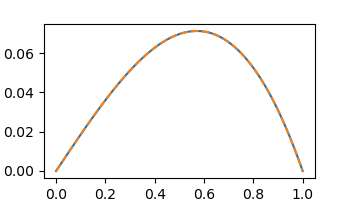

In [5]:
x = torch.linspace(0, 1, steps=100)  # Crea un tensor con 100 puntos equidistantes entre 0 y 1
y_pred = funcion_aprox(x, c).detach().numpy()
y_true = np.sin(x)/np.sin(1) - x
y_true.detach().numpy()
fig = plt.figure(figsize=(3.5, 2.0))
plt.plot(x,y_pred)
plt.plot(x,y_true,'--')
plt.show()

Gráfica del residuo obtenido luego de la optimización.

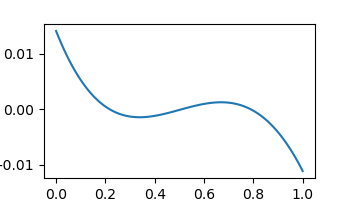

In [6]:
x.requires_grad_(True)
fig = plt.figure(figsize=(3.5, 2.0))
plt.plot(x.detach().numpy(),residuo(x, c).detach().numpy())
plt.show()

Cálculo del error relativo.

In [7]:
#  Error relativo
np.linalg.norm(y_pred-y_true.detach().numpy(),2)/np.linalg.norm(y_true,2)

0.0004109766

## Utilizando diferenciación automática


En lugar de calcular el residuo análiticamente se obtiene con diferenciación automática.

In [8]:
# Derivada
def derivative(dy, x, order=1):
    for _ in range(order):
        dy = torch.autograd.grad(dy, x, grad_outputs=torch.ones_like(dy), create_graph=True, retain_graph=True)[0]
    return dy

# Residuo
def residuo(x, c):
    return derivative(funcion_aprox(x, c), x, order=2) + funcion_aprox(x, c) + x

# Función de pérdida
def loss_fn(x, c):
    y = residuo(x, c)
    return torch.mean(y ** 2)  # Error cuadrático medio

# Configuración de datos y parámetros
x = torch.tensor([1/5, 2/5, 3/5, 4/5], requires_grad=True)

# Inicialización de coeficientes utilizando Xavier
def initialize_coefficients(n):
    std_dev = 1.0 / torch.sqrt(torch.tensor(n, dtype=torch.float32))
    return torch.randn(n) * std_dev

# Configuración del optimizador
c = initialize_coefficients(4).requires_grad_(True)

In [9]:
# Configuración del optimizador
optimizer = torch.optim.Adam([c], lr=0.1)

# Bucle de entrenamiento
num_epochs = 1_000
for epoch in range(num_epochs):
    optimizer.zero_grad()  # Limpiar gradientes previos
    current_loss = loss_fn(x, c)  # Calcular la pérdida
    current_loss.backward()  # Calcular gradientes
    optimizer.step()  # Actualizar parámetros

    if epoch % 100 == 0:  # Mostrar progreso cada 1000 épocas
        print(f'Epoch {epoch}, Loss: {current_loss.item()}, c: {c.data}')

# Resultados optimizados
print(f'Optimized c: {c.data}') 

Epoch 0, Loss: 0.8418203592300415, c: tensor([ 0.3774, -0.0014, -0.4901,  0.9040])
Epoch 100, Loss: 0.001103158458136022, c: tensor([ 0.1499,  0.4240, -0.4817,  0.2956])
Epoch 200, Loss: 0.0007580085657536983, c: tensor([ 0.1574,  0.3834, -0.4021,  0.2468])
Epoch 300, Loss: 0.0004648808971978724, c: tensor([ 0.1641,  0.3411, -0.3170,  0.1913])
Epoch 400, Loss: 0.00025582496891729534, c: tensor([ 0.1704,  0.3017, -0.2378,  0.1396])
Epoch 500, Loss: 0.0001271501969313249, c: tensor([ 0.1757,  0.2683, -0.1707,  0.0958])
Epoch 600, Loss: 5.724454240407795e-05, c: tensor([ 0.1799,  0.2421, -0.1179,  0.0614])
Epoch 700, Loss: 2.3365621018456295e-05, c: tensor([ 0.1829,  0.2228, -0.0791,  0.0361])
Epoch 800, Loss: 8.64212415763177e-06, c: tensor([ 0.1850,  0.2094, -0.0523,  0.0185])
Epoch 900, Loss: 2.8920221666339785e-06, c: tensor([ 0.1864,  0.2007, -0.0347,  0.0071])
Optimized c: tensor([ 1.8729e-01,  1.9534e-01, -2.3892e-02,  4.4299e-05])


Gráfica de la predicción obtenida.

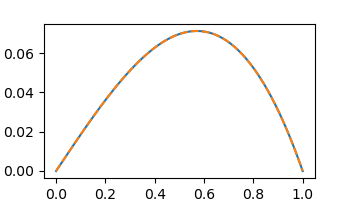

In [10]:
x = torch.linspace(0, 1, steps=100)  # Crea un tensor con 100 puntos equidistantes entre 0 y 1
y_pred = funcion_aprox(x, c).detach().numpy()
y_true = np.sin(x)/np.sin(1) - x
fig = plt.figure(figsize=(3.5, 2.0))
plt.plot(x,y_pred)
plt.plot(x,y_true,'--')
plt.show()

Gráfica el residuo obtenido luego de la optimización.

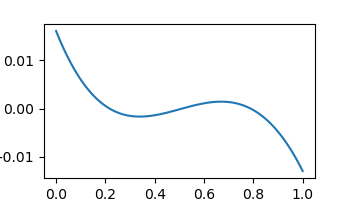

In [11]:
x.requires_grad_(True)
fig = plt.figure(figsize=(3.5, 2.0))
plt.plot(x.detach().numpy(),residuo(x, c).detach().numpy())
plt.show()

Cálculo del error relativo para la apróximación con diferenciación automática.

In [12]:
#  Error relativo
np.linalg.norm(y_pred-y_true.detach().numpy(),2)/np.linalg.norm(y_true,2)

0.00047248005